In [1]:
# Importing library modules

from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
from google.colab.patches import cv2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = 224
BATCH_SIZE = 32

# Path to dataset
dataset_path = '/content/drive/MyDrive/New_IDRiD'

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2  # 80% train, 20% val
)

train_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 2200 images belonging to 5 classes.
Found 550 images belonging to 5 classes.


In [4]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load base
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Unfreezing last N layers
base_model.trainable = True
for layer in base_model.layers[:100]:  # freeze first 100 layers
    layer.trainable = False

print(f"Trainable layers: {sum([layer.trainable for layer in base_model.layers])} / {len(base_model.layers)}")

# Adding head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(224, activation='relu', kernel_initializer='he_uniform')(x)
x = Dropout(0.5)(x)
output = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Trainable layers: 54 / 154


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,546,053 (9.71 MB)

 Trainable params: 2,149,509 (8.20 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [6]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("MobileNet_best_model.keras", monitor='val_accuracy', save_best_only=True, verbose=1)
early = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[checkpoint, early]
)


Epoch 1/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.3372 - loss: 1.6321 
Epoch 1: val_accuracy improved from -inf to 0.31818, saving model to MobileNet_best_model.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 1879s 27s/step - accuracy: 0.3384 - loss: 1.6298 - val_accuracy: 0.3182 - val_loss: 1.6471
Epoch 2/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - accuracy: 0.4987 - loss: 1.2817
Epoch 2: val_accuracy improved from 0.31818 to 0.37636, saving model to MobileNet_best_model.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 45s 643ms/step - accuracy: 0.4992 - loss: 1.2809 - val_accuracy: 0.3764 - val_loss: 1.5072
Epoch 3/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - accuracy: 0.5713 - loss: 1.1792
Epoch 3: val_accuracy improved from 0.37636 to 0.39636, saving model to MobileNet_best_model.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 43s 623ms/step - accuracy: 0.5716 - loss: 1.1784 - val_accuracy: 0.3964 - val_loss: 1.4473
Epoch 4/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.6100 - loss: 1.0434
Epoch 4: 

In [7]:
loss, acc = model.evaluate(val_gen)
print(f"Validation Accuracy: {acc:.4f}")


18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 434ms/step - accuracy: 0.6696 - loss: 0.8207
Validation Accuracy: 0.6945


18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 642ms/step
Class names: ['Healthy', 'Mild DR', 'Moderate DR', 'Proliferate DR', 'Severe DR']
Confusion Matrix:
[[84 38 72  2  4]
 [28 14 29  2  1]
 [62 39 73  2  4]
 [27  8 23  0  0]
 [15  7 15  0  1]]

Classification Report:
                precision    recall  f1-score   support

       Healthy       0.39      0.42      0.40       200
       Mild DR       0.13      0.19      0.16        74
   Moderate DR       0.34      0.41      0.37       180
Proliferate DR       0.00      0.00      0.00        58
     Severe DR       0.10      0.03      0.04        38

      accuracy                           0.31       550
     macro avg       0.19      0.21      0.19       550
  weighted avg       0.28      0.31      0.29       550



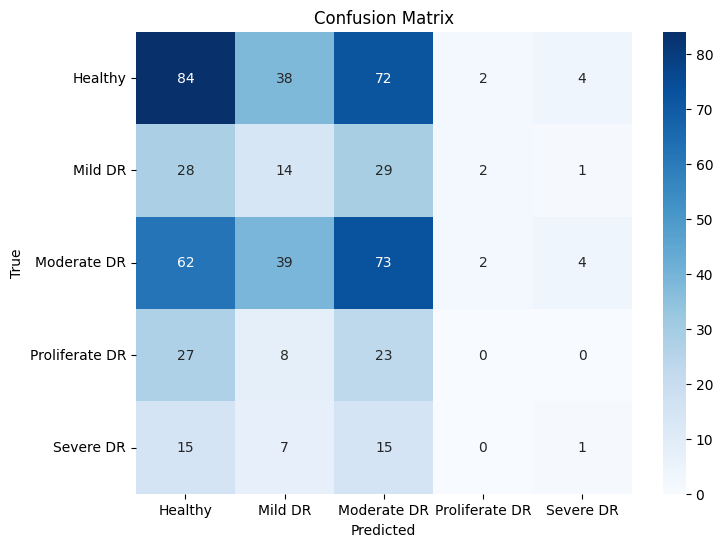

In [8]:
import numpy as np

# Predict probabilities for all validation batches
y_pred_probs = model.predict(val_gen, verbose=1)

# Converting it to class index (0-4)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# These are the *true* labels used by the generator
y_true = val_gen.classes

# Maping indices back to folder names
class_names = list(val_gen.class_indices.keys())
print("Class names:", class_names)

from sklearn.metrics import confusion_matrix, classification_report

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(cm)

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# plotting confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

